In [233]:
import pandas as pd
import numpy as np

import scipy

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Next we will import the data. There are 3 files: 
* Stats file which we downloaded from [Kaggle](https://www.kaggle.com/tlegrand/pokemon-with-stats-generation-8). However, most pokemons have their types wrong and I have cleaned them (some). 
* Pokemon battle dataset from [Kaggle](https://www.kaggle.com/terminus7/pokemon-challenge). 

In [316]:
stats_df = pd.read_csv('Pokemon_Gen_1-8.csv', encoding='cp1252')
data_df = pd.read_csv('combats.csv')

Let us see the heads of the datasets. 

In [235]:
print('=== Pokemon ===')
print(stats_df.head())
print('\n=== Battle Data ===')
print(data_df.head())

=== Pokemon ===
   #                      Name Type 1  Type 2  HP  Attack  Defense  \
0  1                 Bulbasaur  Grass  Poison  45      49       49   
1  2                   Ivysaur  Grass  Poison  60      62       63   
2  3                  Venusaur  Grass  Poison  80      82       83   
3  3  Venusaur (Mega Venusaur)  Grass  Poison  80     100      123   
4  4                Charmander   Fire     NaN  39      52       43   

   Sp. Attack  Sp. Defense  Speed  Total  Average  Generation  Legendary  
0          65           65     45    318    53.00           1          0  
1          80           80     60    405    67.50           1          0  
2         100          100     80    525    87.50           1          0  
3         122          120     80    625   104.17           1          0  
4          60           50     65    309    51.50           1          0  

=== Battle Data ===
   First_pokemon  Second_pokemon  Winner
0            266             298     298
1         

## EDA (Pokemon Stats)

In [5]:
print('There are {} rows and {} columns in the Pokemon stats dataframe.'.format(stats_df.shape[0], stats_df.shape[1]))
print()
print('=== Columns ===')
# for i in range(len(stats_df.columns)):
#     print(stats_df.columns[i], stats_df.dtypes.values[i])
stats_df.info()

There are 1018 rows and 14 columns in the Pokemon stats dataframe.

=== Columns ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 14 columns):
#              1018 non-null int64
Name           1018 non-null object
Type 1         1018 non-null object
Type 2         555 non-null object
HP             1018 non-null int64
Attack         1018 non-null int64
Defense        1018 non-null int64
Sp. Attack     1018 non-null int64
Sp. Defense    1018 non-null int64
Speed          1018 non-null int64
Total          1018 non-null int64
Average        1018 non-null float64
Generation     1018 non-null int64
Legendary      1018 non-null int64
dtypes: float64(1), int64(10), object(3)
memory usage: 111.4+ KB


In the dataset, you can see if a Pokemon has different forms then they will duplicate their rows. This should be cautious when combining with the other dataset. 

In [6]:
print(stats_df['#'].unique().shape[0])

890


Who are the ones that have different forms?

In [223]:
print(stats_df[stats_df.duplicated(subset=['#'],keep=False)])

        #                              Name      Type 1    Type 2   HP  \
2       3                          Venusaur       Grass    Poison   80   
3       3          Venusaur (Mega Venusaur)       Grass    Poison   80   
6       6                         Charizard        Fire    Flying   78   
7       6      Charizard (Mega Charizard X)        Fire    Dragon   78   
8       6      Charizard (Mega Charizard Y)        Fire    Flying   78   
11      9                         Blastoise       Water       NaN   79   
12      9        Blastoise (Mega Blastoise)       Water       NaN   79   
18     15                          Beedrill         Bug    Poison   65   
19     15          Beedrill (Mega Beedrill)         Bug    Poison   65   
22     18                           Pidgeot      Normal    Flying   83   
23     18            Pidgeot (Mega Pidgeot)      Normal    Flying   83   
24     19                           Rattata      Normal       NaN   30   
25     19          Rattata (Alolan Rat

One thing we need to change before continue is to make sure the column names are alphabetical characters. So we will convert them in below. 

In [317]:
stats_df = stats_df.rename(columns={'#':'No','Type 1':'Type1', 'Type 2':'Type2'})

As you can see that Pokemon have different types mean they have different types as well. This is important when we infer from the battle dataframe. 

In [318]:
stats_n_df = stats_df.drop_duplicates(subset='No', keep='first')
stats_n_df = stats_n_df.reset_index()
print(stats_n_df.head(10))

   index  No        Name  Type1   Type2  HP  Attack  Defense  Sp. Attack  \
0      0   1   Bulbasaur  Grass  Poison  45      49       49          65   
1      1   2     Ivysaur  Grass  Poison  60      62       63          80   
2      2   3    Venusaur  Grass  Poison  80      82       83         100   
3      4   4  Charmander   Fire     NaN  39      52       43          60   
4      5   5  Charmeleon   Fire     NaN  58      64       58          80   
5      6   6   Charizard   Fire  Flying  78      84       78         109   
6      9   7    Squirtle  Water     NaN  44      48       65          50   
7     10   8   Wartortle  Water     NaN  59      63       80          65   
8     11   9   Blastoise  Water     NaN  79      83      100          85   
9     13  10    Caterpie    Bug     NaN  45      30       35          20   

   Sp. Defense  Speed  Total  Average  Generation  Legendary  
0           65     45    318    53.00           1          0  
1           80     60    405    67.50

In [319]:
print(stats_df['Type1'].unique())

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Dark' 'Poison' 'Electric' 'Ground'
 'Ice' 'Fairy' 'Steel' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Dragon'
 'Flying' 'Grass\n' 'Fighting\n']


We have some Pokemon types that has an extra new line character, so we need to replace them. (__09/02/2020 Note:__ This can be eliminated once I have cleaned the Pokemon dataset fully)

In [320]:
# stats_df = stats_df.replace({'Type1':{'Grass\n':'Grass', 'Rock\n':'Rock', 'Fighting\n':'Fighting'}})
stats_df = stats_df.replace({'Type1':{'Grass\n':'Grass', 'Fighting\n':'Fighting'}})
print(stats_df['Type1'].unique())

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Dark' 'Poison' 'Electric' 'Ground'
 'Ice' 'Fairy' 'Steel' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Dragon'
 'Flying']


Let us look at the descriptive stats of the Pokemons. 

In [229]:
stats_df.describe()

,No,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Generation,Legendary
count,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,435.436149,69.590373,80.182711,74.525540,72.596267,72.139489,68.282908,437.317289,72.886110,4.233792,0.066798
std,259.549656,26.498774,32.480022,31.406208,32.725657,28.179998,29.889645,122.090092,20.348427,2.303082,0.249794
min,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,175.000000,29.170000,1.000000,0.000000
25%,211.250000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,330.000000,55.000000,2.000000,0.000000
50%,430.500000,65.500000,77.000000,70.000000,65.000000,70.000000,65.000000,455.000000,75.830000,4.000000,0.000000
75%,659.750000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,510.000000,85.000000,6.000000,0.000000
max,890.000000,255.000000,190.000000,250.000000,194.000000,250.000000,180.000000,1125.000000,187.500000,8.000000,1.000000


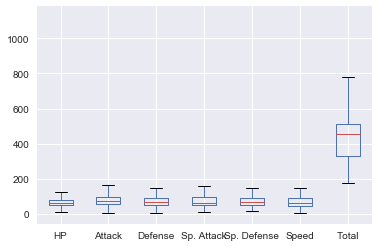

In [41]:
stats_df.boxplot(['HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed', 'Total'])
plt.show()

In [42]:
print(stats_df['Type1'].value_counts())

Water       125
Normal      113
Psychic      86
Grass        80
Bug          76
Fire         64
Electric     59
Rock         57
Dragon       52
Ghost        43
Ground       42
Steel        41
Dark         40
Poison       39
Fighting     37
Ice          34
Fairy        20
Flying       10
Name: Type1, dtype: int64


In [20]:
stats_df.corr()

,No,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Generation,Legendary
No,1.000000,0.103643,0.113603,0.098829,0.092531,0.089286,0.005006,0.124776,0.124774,0.988744,0.114662
HP,0.103643,1.000000,0.444051,0.301623,0.367076,0.397512,0.186156,0.648482,0.648481,0.108988,0.255187
Attack,0.113603,0.444051,1.000000,0.452612,0.378008,0.266396,0.384672,0.735825,0.735821,0.121911,0.268999
Defense,0.098829,0.301623,0.452612,1.000000,0.226004,0.540874,0.010149,0.631018,0.631018,0.103369,0.231156
Sp. Attack,0.092531,0.367076,0.378008,0.226004,1.000000,0.513264,0.442223,0.733147,0.733148,0.105805,0.321695
Sp. Defense,0.089286,0.397512,0.266396,0.540874,0.513264,1.000000,0.236309,0.722524,0.722522,0.101430,0.320654
Speed,0.005006,0.186156,0.384672,0.010149,0.442223,0.236309,1.000000,0.563245,0.563250,0.025049,0.254539
Total,0.124776,0.648482,0.735825,0.631018,0.733147,0.722524,0.563245,1.000000,1.000000,0.140583,0.408966
Average,0.124774,0.648481,0.735821,0.631018,0.733148,0.722522,0.563250,1.000000,1.000000,0.140581,0.408971
Generation,0.988744,0.108988,0.121911,0.103369,0.105805,0.101430,0.025049,0.140583,0.140581,1.000000,0.147164


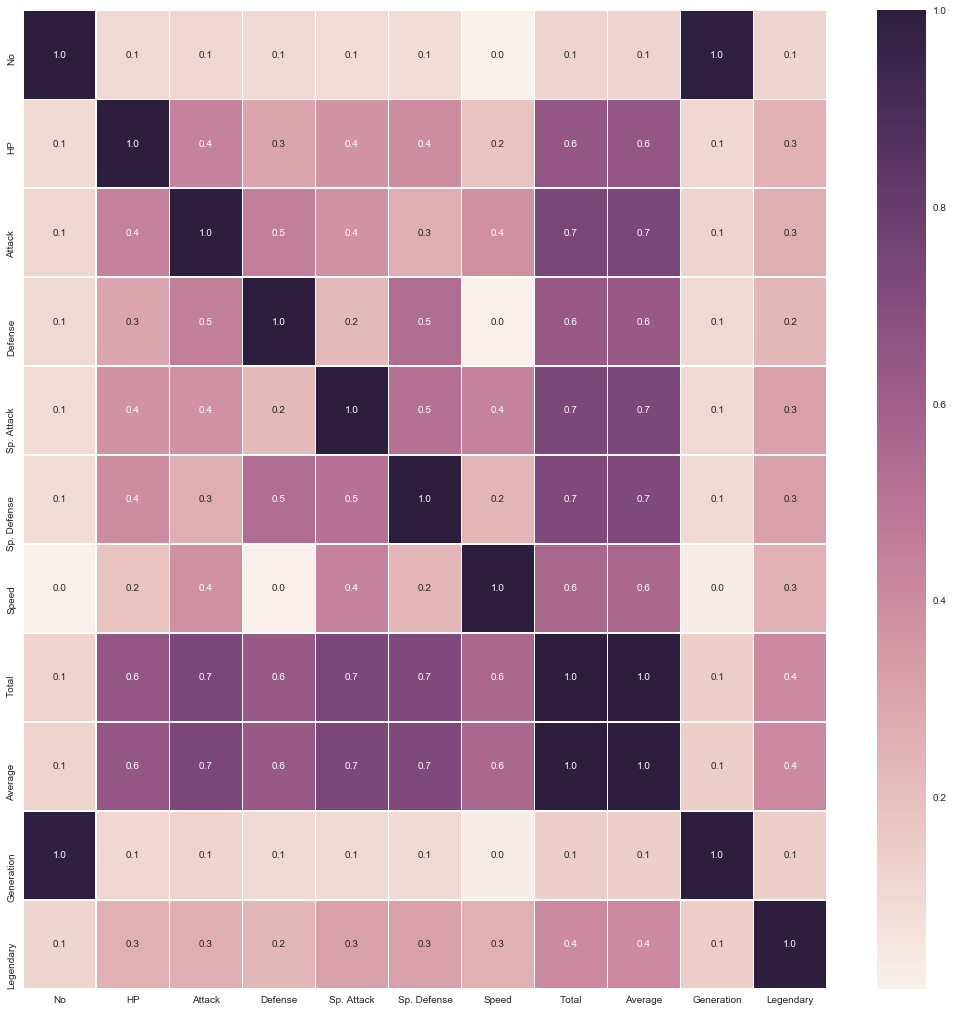

In [230]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(stats_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

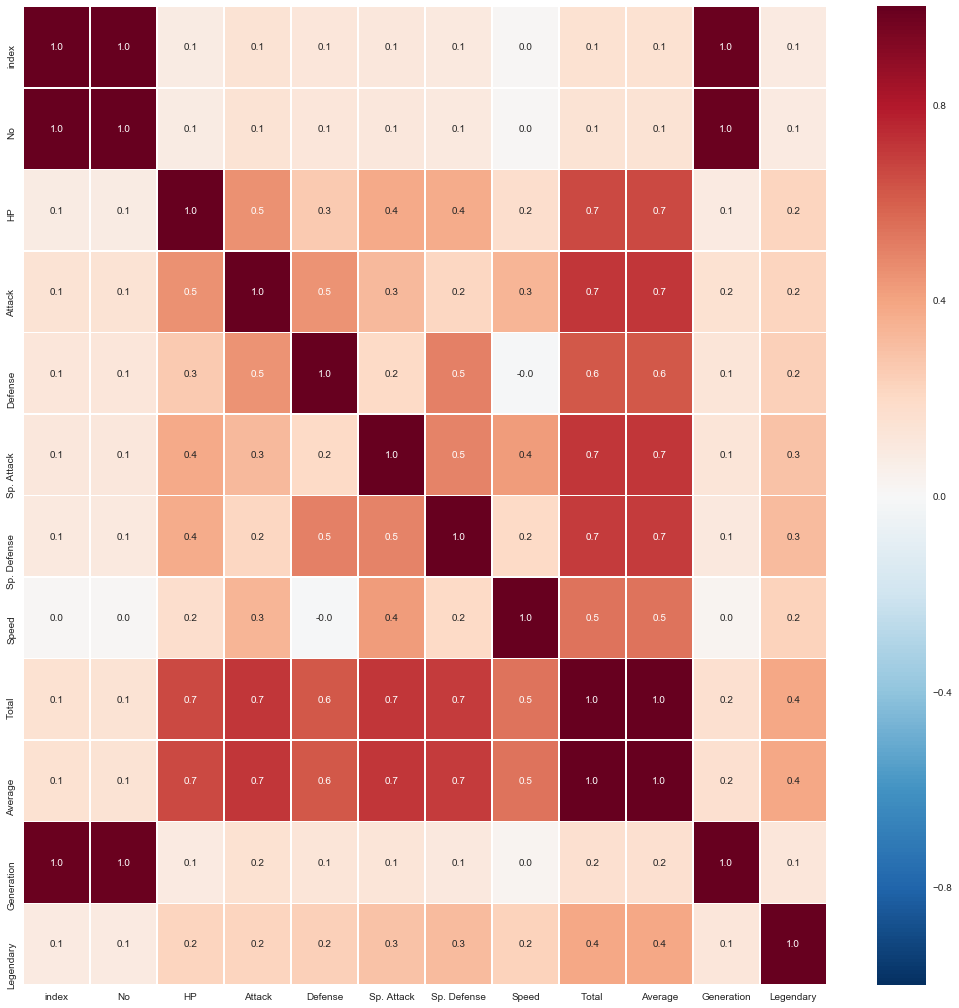

In [231]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(stats_n_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Let us drill down to the basic stats of the Pokemons. 

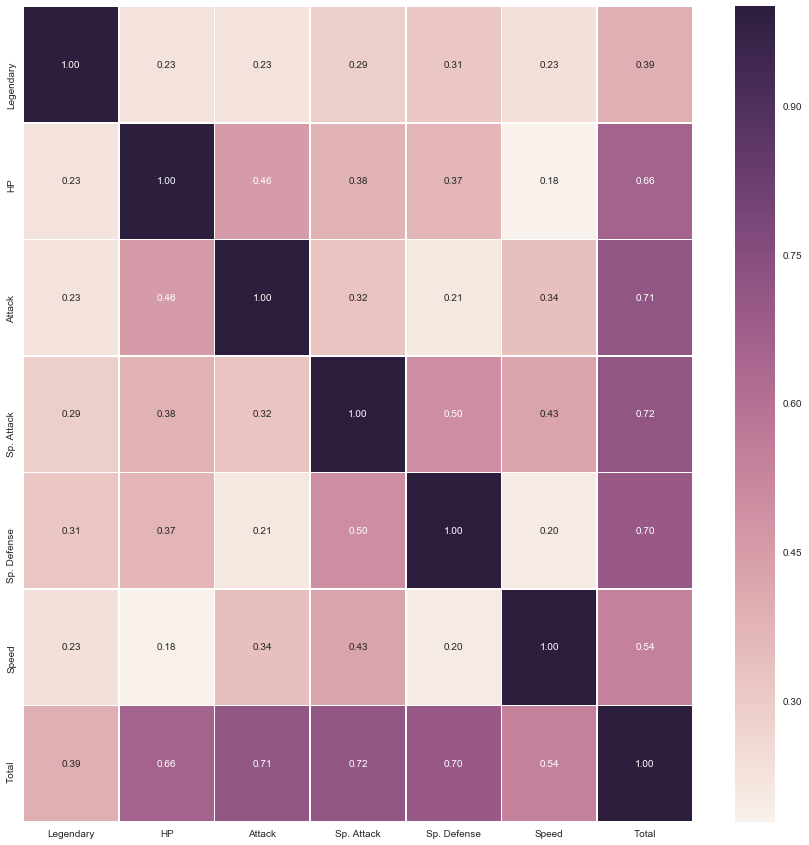

In [50]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(stats_n_df[['Legendary','HP','Attack','Sp. Attack','Sp. Defense','Speed','Total']].corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

Among all the basic stats, only speed is not that correlated as other ones. Legendary Pokemons does not have strong correlation with its total stats. 

## EDA (Pokemon Battle Stats)

In [18]:
data_df.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [19]:
print('There are {} rows and {} columns in the Pokemon stats dataframe.'.format(data_df.shape[0], data_df.shape[1]))
print()
print('=== Columns ===')
for i in range(len(data_df.columns)):
    print(data_df.columns[i], data_df.dtypes.values[i])

There are 50000 rows and 3 columns in the Pokemon stats dataframe.

=== Columns ===
First_pokemon int64
Second_pokemon int64
Winner int64


In [20]:
print(data_df.groupby(['Winner']).count().head(20))

        First_pokemon  Second_pokemon
Winner                               
1                  37              37
2                  46              46
3                  89              89
4                  70              70
5                  55              55
6                  64              64
7                 115             115
8                 119             119
9                 114             114
10                 19              19
11                 59              59
13                 83              83
14                 17              17
15                 13              13
16                 75              75
17                 26              26
18                 17              17
19                 80              80
20                115             115
21                 47              47


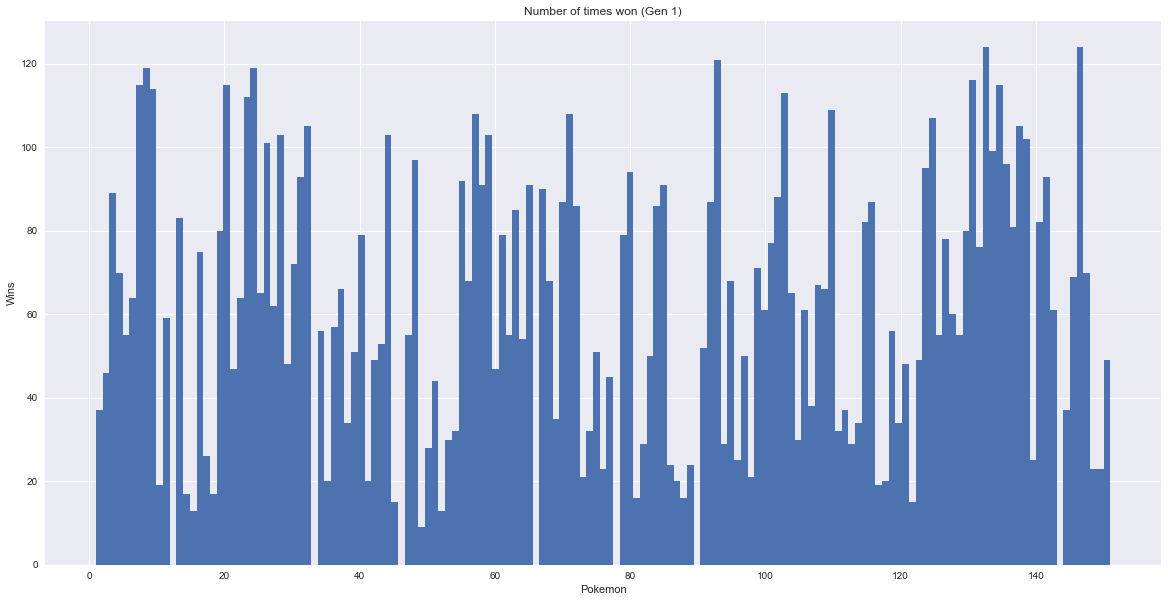

In [21]:
plt.figure(figsize=(20,10))
plt.title('Number of times won (Gen 1)')
plt.xlabel('Pokemon')
plt.ylabel('Wins')
plt.hist(data_df.loc[data_df.Winner <= 151,'Winner'], bins=151)
plt.show()

In [59]:
print(data_df.loc[(data_df.Winner <= 151), 'Winner'].value_counts().sort_values(ascending=True).head(20))
print()
print(stats_n_df.loc[(stats_n_df.No <= 151) & (stats_n_df.Type1 == 'Fire'), ['No', 'Name']])
print()
# print(stats_n_df.loc[(stats_n_df.No <= 151) & (stats_n_df.Type1 == 'Fire'), 'No'].values.tolist())
query01_0 = stats_n_df.loc[(stats_n_df.No <= 151) & (stats_n_df.Type1 == 'Fire'), 'No'].values.tolist()
query01_1 = data_df.loc[(data_df.Winner <= 151), 'Winner'].value_counts()
print(query01_1[query01_1.index.isin(query01_0)].sort_index())


49      9
52     13
15     13
45     15
122    15
88     16
81     16
18     17
14     17
10     19
117    19
118    20
41     20
35     20
87     20
98     21
73     21
76     23
149    23
150    23
Name: Winner, dtype: int64

      No        Name
3      4  Charmander
4      5  Charmeleon
5      6   Charizard
30    31   Nidoqueen
31    32    Nidoran♂
49    50     Diglett
64    65    Alakazam
104  105     Marowak
114  115  Kangaskhan
123  124        Jynx
132  133       Eevee
133  134    Vaporeon

4       70
5       55
6       64
31      93
32     105
50      28
65      91
105     30
115     82
124     95
133    124
134     99
Name: Winner, dtype: int64


In [46]:
def hist_types(stats_df, data_df, type_q, l=1, u=151):
    type_list = stats_n_df['Type1'].unique()
#     print(type_list)
    query_0 = stats_n_df.loc[(stats_n_df.No >= l) & (stats_n_df.No <= u) & (stats_n_df.Type1 == type_q), 'No'].values.tolist()
    query_1 = data_df.loc[(data_df.Winner >= l), 'Winner'].value_counts()
    return query_1[query_1.index.isin(query_0)].sort_index()

# ['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground' 'Fairy'
# 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel' 'Flying']



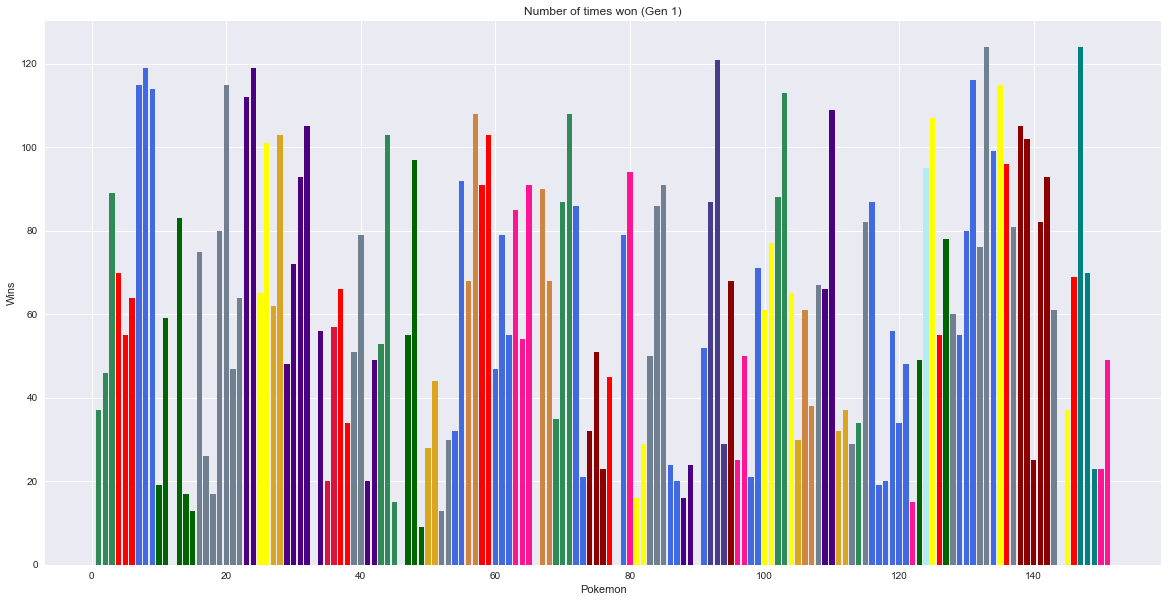

In [47]:
plt.figure(figsize=(20,10))
plt.title('Number of times won (Gen 1)')
plt.xlabel('Pokemon')
plt.ylabel('Wins')
plt.bar(hist_types(stats_n_df, data_df, 'Grass').index, hist_types(stats_n_df, data_df, 'Grass'), color='seagreen')
plt.bar(hist_types(stats_n_df, data_df, 'Fire').index, hist_types(stats_n_df, data_df, 'Fire'), color='Red')
plt.bar(hist_types(stats_n_df, data_df, 'Water').index, hist_types(stats_n_df, data_df, 'Water'), color='royalblue')
plt.bar(hist_types(stats_n_df, data_df, 'Bug').index, hist_types(stats_n_df, data_df, 'Bug'), color='darkgreen')
plt.bar(hist_types(stats_n_df, data_df, 'Normal').index, hist_types(stats_n_df, data_df, 'Normal'), color='slategrey')
plt.bar(hist_types(stats_n_df, data_df, 'Poison').index, hist_types(stats_n_df, data_df, 'Poison'), color='indigo')
plt.bar(hist_types(stats_n_df, data_df, 'Electric').index, hist_types(stats_n_df, data_df, 'Electric'), color='yellow')
plt.bar(hist_types(stats_n_df, data_df, 'Ground').index, hist_types(stats_n_df, data_df, 'Ground'), color='goldenrod')
plt.bar(hist_types(stats_n_df, data_df, 'Fairy').index, hist_types(stats_n_df, data_df, 'Fairy'), color='crimson')
plt.bar(hist_types(stats_n_df, data_df, 'Fighting').index, hist_types(stats_n_df, data_df, 'Fighting'), color='peru')
plt.bar(hist_types(stats_n_df, data_df, 'Psychic').index, hist_types(stats_n_df, data_df, 'Psychic'), color='deeppink')
plt.bar(hist_types(stats_n_df, data_df, 'Rock').index, hist_types(stats_n_df, data_df, 'Rock'), color='darkred')
plt.bar(hist_types(stats_n_df, data_df, 'Ghost').index, hist_types(stats_n_df, data_df, 'Ghost'), color='darkslateblue')
plt.bar(hist_types(stats_n_df, data_df, 'Ice').index, hist_types(stats_n_df, data_df, 'Ice'), color='paleturquoise')
plt.bar(hist_types(stats_n_df, data_df, 'Dragon').index, hist_types(stats_n_df, data_df, 'Dragon'), color='teal')
plt.bar(hist_types(stats_n_df, data_df, 'Dark').index, hist_types(stats_n_df, data_df, 'Dark'), color='black')
plt.bar(hist_types(stats_n_df, data_df, 'Steel').index, hist_types(stats_n_df, data_df, 'Steel'), color='cadetblue')
plt.bar(hist_types(stats_n_df, data_df, 'Flying').index, hist_types(stats_n_df, data_df, 'Flying'), color='deepskyblue')
plt.show()

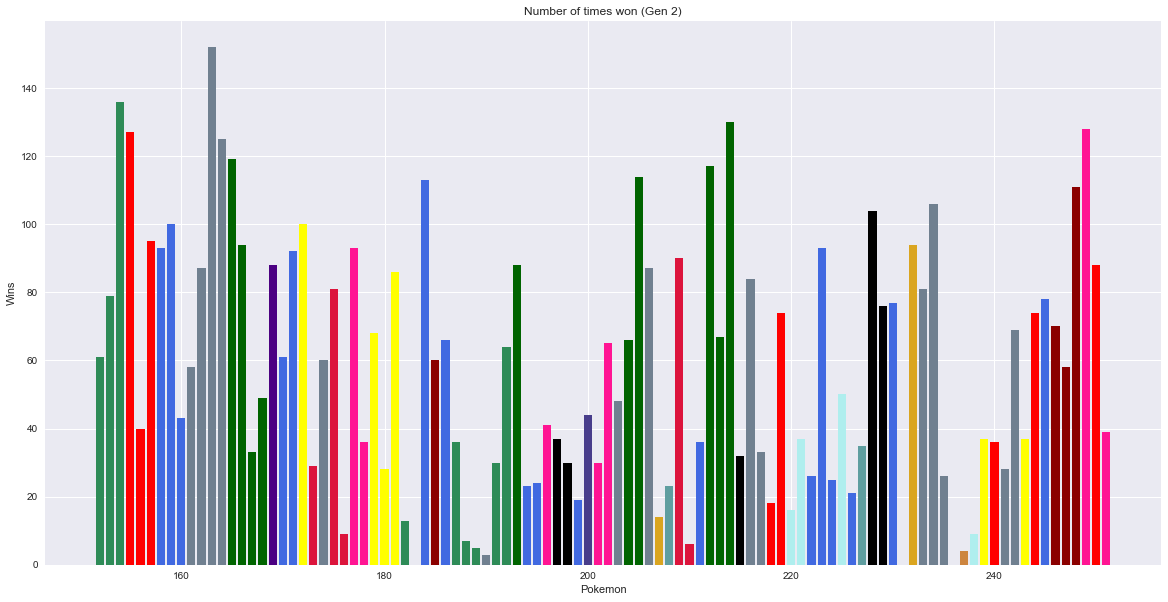

In [232]:
# print(hist_types(stats_n_df, data_df, 'Grass', 152, 251))

plt.figure(figsize=(20,10))
plt.title('Number of times won (Gen 2)')
plt.xlabel('Pokemon')
plt.ylabel('Wins')
plt.bar(hist_types(stats_n_df, data_df, 'Grass', 152, 251).index, hist_types(stats_n_df, data_df, 'Grass', 152, 251), color='seagreen')
plt.bar(hist_types(stats_n_df, data_df, 'Fire', 152, 251).index, hist_types(stats_n_df, data_df, 'Fire', 152, 251), color='Red')
plt.bar(hist_types(stats_n_df, data_df, 'Water', 152, 251).index, hist_types(stats_n_df, data_df, 'Water', 152, 251), color='royalblue')
plt.bar(hist_types(stats_n_df, data_df, 'Bug', 152, 251).index, hist_types(stats_n_df, data_df, 'Bug', 152, 251), color='darkgreen')
plt.bar(hist_types(stats_n_df, data_df, 'Normal', 152, 251).index, hist_types(stats_n_df, data_df, 'Normal', 152, 251), color='slategrey')
plt.bar(hist_types(stats_n_df, data_df, 'Poison', 152, 251).index, hist_types(stats_n_df, data_df, 'Poison', 152, 251), color='indigo')
plt.bar(hist_types(stats_n_df, data_df, 'Electric', 152, 251).index, hist_types(stats_n_df, data_df, 'Electric', 152, 251), color='yellow')
plt.bar(hist_types(stats_n_df, data_df, 'Ground', 152, 251).index, hist_types(stats_n_df, data_df, 'Ground', 152, 251), color='goldenrod')
plt.bar(hist_types(stats_n_df, data_df, 'Fairy', 152, 251).index, hist_types(stats_n_df, data_df, 'Fairy', 152, 251), color='crimson')
plt.bar(hist_types(stats_n_df, data_df, 'Fighting', 152, 251).index, hist_types(stats_n_df, data_df, 'Fighting', 152, 251), color='peru')
plt.bar(hist_types(stats_n_df, data_df, 'Psychic', 152, 251).index, hist_types(stats_n_df, data_df, 'Psychic', 152, 251), color='deeppink')
plt.bar(hist_types(stats_n_df, data_df, 'Rock', 152, 251).index, hist_types(stats_n_df, data_df, 'Rock', 152, 251), color='darkred')
plt.bar(hist_types(stats_n_df, data_df, 'Ghost', 152, 251).index, hist_types(stats_n_df, data_df, 'Ghost', 152, 251), color='darkslateblue')
plt.bar(hist_types(stats_n_df, data_df, 'Ice', 152, 251).index, hist_types(stats_n_df, data_df, 'Ice', 152, 251), color='paleturquoise')
plt.bar(hist_types(stats_n_df, data_df, 'Dragon', 152, 251).index, hist_types(stats_n_df, data_df, 'Dragon', 152, 251), color='teal')
plt.bar(hist_types(stats_n_df, data_df, 'Dark', 152, 251).index, hist_types(stats_n_df, data_df, 'Dark', 152, 251), color='black')
plt.bar(hist_types(stats_n_df, data_df, 'Steel', 152, 251).index, hist_types(stats_n_df, data_df, 'Steel', 152, 251), color='cadetblue')
plt.bar(hist_types(stats_n_df, data_df, 'Flying', 152, 251).index, hist_types(stats_n_df, data_df, 'Flying', 152, 251), color='deepskyblue')
plt.show()

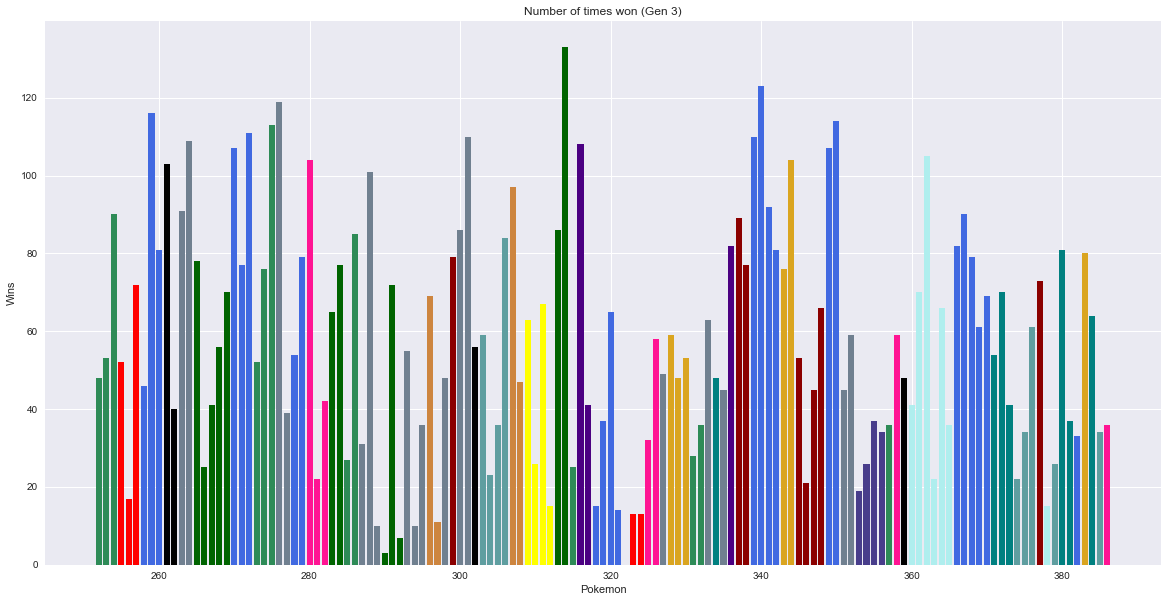

In [238]:
plt.figure(figsize=(20,10))
plt.title('Number of times won (Gen 3)')
plt.xlabel('Pokemon')
plt.ylabel('Wins')
plt.bar(hist_types(stats_n_df, data_df, 'Grass', 252, 386).index, hist_types(stats_n_df, data_df, 'Grass', 252, 386), color='seagreen')
plt.bar(hist_types(stats_n_df, data_df, 'Fire', 252, 386).index, hist_types(stats_n_df, data_df, 'Fire', 252, 386), color='Red')
plt.bar(hist_types(stats_n_df, data_df, 'Water', 252, 386).index, hist_types(stats_n_df, data_df, 'Water', 252, 386), color='royalblue')
plt.bar(hist_types(stats_n_df, data_df, 'Bug', 252, 386).index, hist_types(stats_n_df, data_df, 'Bug', 252, 386), color='darkgreen')
plt.bar(hist_types(stats_n_df, data_df, 'Normal', 252, 386).index, hist_types(stats_n_df, data_df, 'Normal', 252, 386), color='slategrey')
plt.bar(hist_types(stats_n_df, data_df, 'Poison', 252, 386).index, hist_types(stats_n_df, data_df, 'Poison', 252, 386), color='indigo')
plt.bar(hist_types(stats_n_df, data_df, 'Electric', 252, 386).index, hist_types(stats_n_df, data_df, 'Electric', 252, 386), color='yellow')
plt.bar(hist_types(stats_n_df, data_df, 'Ground', 252, 386).index, hist_types(stats_n_df, data_df, 'Ground', 252, 386), color='goldenrod')
plt.bar(hist_types(stats_n_df, data_df, 'Fairy', 252, 386).index, hist_types(stats_n_df, data_df, 'Fairy', 252, 386), color='crimson')
plt.bar(hist_types(stats_n_df, data_df, 'Fighting', 252, 386).index, hist_types(stats_n_df, data_df, 'Fighting', 252, 386), color='peru')
plt.bar(hist_types(stats_n_df, data_df, 'Psychic', 252, 386).index, hist_types(stats_n_df, data_df, 'Psychic', 252, 386), color='deeppink')
plt.bar(hist_types(stats_n_df, data_df, 'Rock', 252, 386).index, hist_types(stats_n_df, data_df, 'Rock', 252, 386), color='darkred')
plt.bar(hist_types(stats_n_df, data_df, 'Ghost', 252, 386).index, hist_types(stats_n_df, data_df, 'Ghost', 252, 386), color='darkslateblue')
plt.bar(hist_types(stats_n_df, data_df, 'Ice', 252, 386).index, hist_types(stats_n_df, data_df, 'Ice', 252, 386), color='paleturquoise')
plt.bar(hist_types(stats_n_df, data_df, 'Dragon', 252, 386).index, hist_types(stats_n_df, data_df, 'Dragon', 252, 386), color='teal')
plt.bar(hist_types(stats_n_df, data_df, 'Dark', 252, 386).index, hist_types(stats_n_df, data_df, 'Dark', 252, 386), color='black')
plt.bar(hist_types(stats_n_df, data_df, 'Steel', 252, 386).index, hist_types(stats_n_df, data_df, 'Steel', 252, 386), color='cadetblue')
plt.bar(hist_types(stats_n_df, data_df, 'Flying', 252, 386).index, hist_types(stats_n_df, data_df, 'Flying', 252, 386), color='deepskyblue')
plt.show()

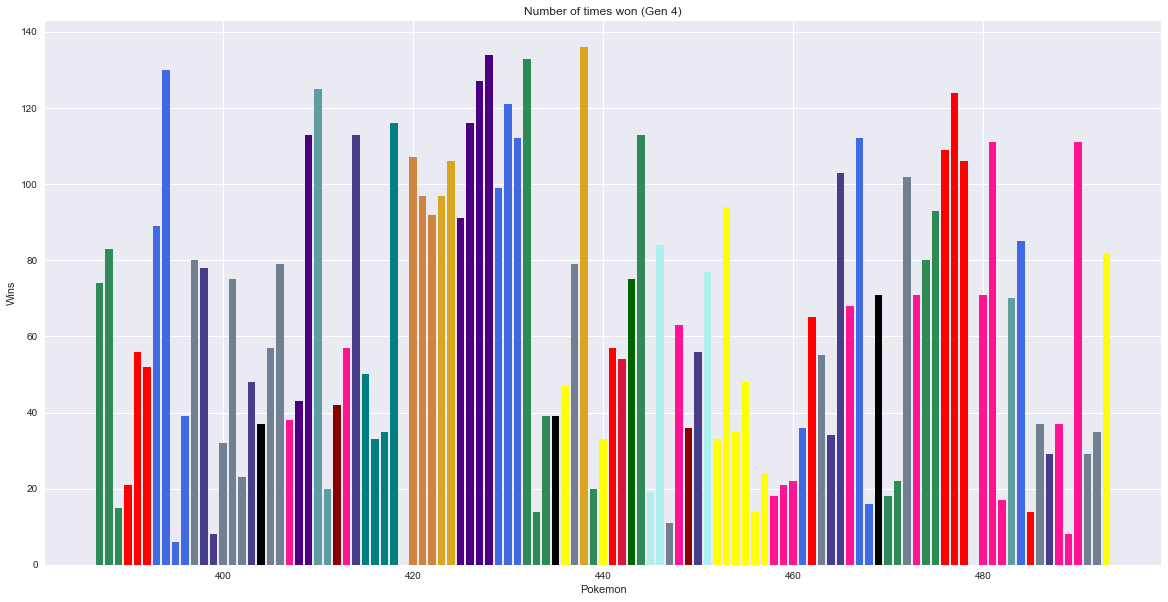

In [239]:
plt.figure(figsize=(20,10))
plt.title('Number of times won (Gen 4)')
plt.xlabel('Pokemon')
plt.ylabel('Wins')
plt.bar(hist_types(stats_n_df, data_df, 'Grass', 387, 493).index, hist_types(stats_n_df, data_df, 'Grass', 387, 493), color='seagreen')
plt.bar(hist_types(stats_n_df, data_df, 'Fire', 387, 493).index, hist_types(stats_n_df, data_df, 'Fire', 387, 493), color='Red')
plt.bar(hist_types(stats_n_df, data_df, 'Water', 387, 493).index, hist_types(stats_n_df, data_df, 'Water', 387, 493), color='royalblue')
plt.bar(hist_types(stats_n_df, data_df, 'Bug', 387, 493).index, hist_types(stats_n_df, data_df, 'Bug', 387, 493), color='darkgreen')
plt.bar(hist_types(stats_n_df, data_df, 'Normal', 387, 493).index, hist_types(stats_n_df, data_df, 'Normal', 387, 493), color='slategrey')
plt.bar(hist_types(stats_n_df, data_df, 'Poison', 387, 493).index, hist_types(stats_n_df, data_df, 'Poison', 387, 493), color='indigo')
plt.bar(hist_types(stats_n_df, data_df, 'Electric', 387, 493).index, hist_types(stats_n_df, data_df, 'Electric', 387, 493), color='yellow')
plt.bar(hist_types(stats_n_df, data_df, 'Ground', 387, 493).index, hist_types(stats_n_df, data_df, 'Ground', 387, 493), color='goldenrod')
plt.bar(hist_types(stats_n_df, data_df, 'Fairy', 387, 493).index, hist_types(stats_n_df, data_df, 'Fairy', 387, 493), color='crimson')
plt.bar(hist_types(stats_n_df, data_df, 'Fighting', 387, 493).index, hist_types(stats_n_df, data_df, 'Fighting', 387, 493), color='peru')
plt.bar(hist_types(stats_n_df, data_df, 'Psychic', 387, 493).index, hist_types(stats_n_df, data_df, 'Psychic', 387, 493), color='deeppink')
plt.bar(hist_types(stats_n_df, data_df, 'Rock', 387, 493).index, hist_types(stats_n_df, data_df, 'Rock', 387, 493), color='darkred')
plt.bar(hist_types(stats_n_df, data_df, 'Ghost', 387, 493).index, hist_types(stats_n_df, data_df, 'Ghost', 387, 493), color='darkslateblue')
plt.bar(hist_types(stats_n_df, data_df, 'Ice', 387, 493).index, hist_types(stats_n_df, data_df, 'Ice', 387, 493), color='paleturquoise')
plt.bar(hist_types(stats_n_df, data_df, 'Dragon', 387, 493).index, hist_types(stats_n_df, data_df, 'Dragon', 387, 493), color='teal')
plt.bar(hist_types(stats_n_df, data_df, 'Dark', 387, 493).index, hist_types(stats_n_df, data_df, 'Dark', 387, 493), color='black')
plt.bar(hist_types(stats_n_df, data_df, 'Steel', 387, 493).index, hist_types(stats_n_df, data_df, 'Steel', 387, 493), color='cadetblue')
plt.bar(hist_types(stats_n_df, data_df, 'Flying', 387, 493).index, hist_types(stats_n_df, data_df, 'Flying', 387, 493), color='deepskyblue')
plt.show()

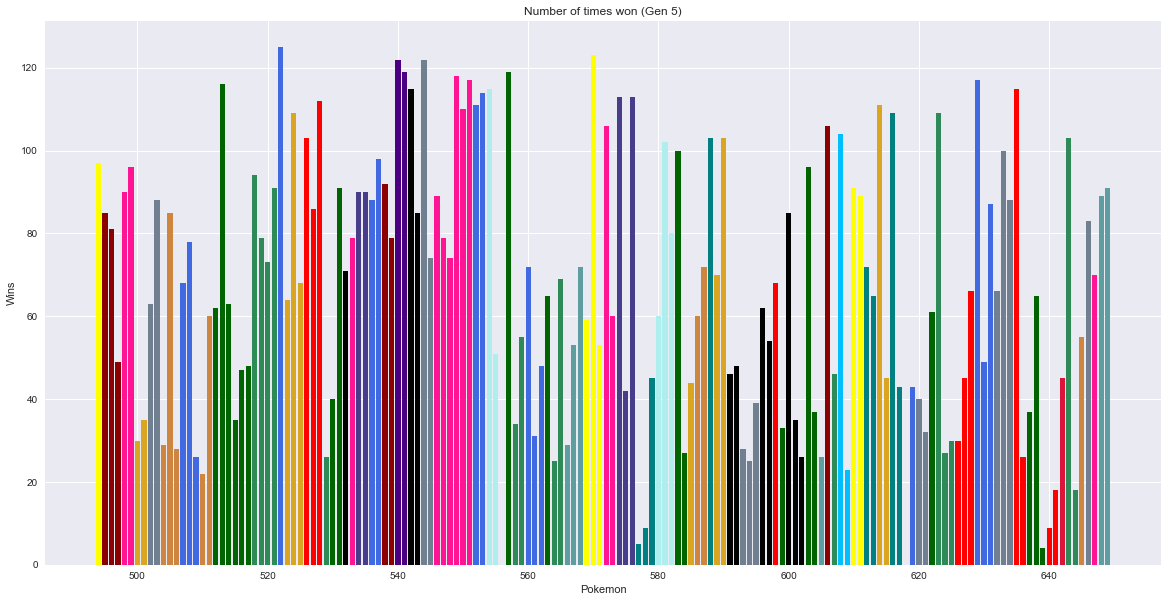

In [112]:
plt.figure(figsize=(20,10))
plt.title('Number of times won (Gen 5)')
plt.xlabel('Pokemon')
plt.ylabel('Wins')
plt.bar(hist_types(stats_n_df, data_df, 'Grass', 494, 649).index, hist_types(stats_n_df, data_df, 'Grass', 494, 649), color='seagreen')
plt.bar(hist_types(stats_n_df, data_df, 'Fire', 494, 649).index, hist_types(stats_n_df, data_df, 'Fire', 494, 649), color='Red')
plt.bar(hist_types(stats_n_df, data_df, 'Water', 494, 649).index, hist_types(stats_n_df, data_df, 'Water', 494, 649), color='royalblue')
plt.bar(hist_types(stats_n_df, data_df, 'Bug', 494, 649).index, hist_types(stats_n_df, data_df, 'Bug', 494, 649), color='darkgreen')
plt.bar(hist_types(stats_n_df, data_df, 'Normal', 494, 649).index, hist_types(stats_n_df, data_df, 'Normal', 494, 649), color='slategrey')
plt.bar(hist_types(stats_n_df, data_df, 'Poison', 494, 649).index, hist_types(stats_n_df, data_df, 'Poison', 494, 649), color='indigo')
plt.bar(hist_types(stats_n_df, data_df, 'Electric', 494, 649).index, hist_types(stats_n_df, data_df, 'Electric', 494, 649), color='yellow')
plt.bar(hist_types(stats_n_df, data_df, 'Ground', 494, 649).index, hist_types(stats_n_df, data_df, 'Ground', 494, 649), color='goldenrod')
plt.bar(hist_types(stats_n_df, data_df, 'Fairy', 494, 649).index, hist_types(stats_n_df, data_df, 'Fairy', 494, 649), color='crimson')
plt.bar(hist_types(stats_n_df, data_df, 'Fighting', 494, 649).index, hist_types(stats_n_df, data_df, 'Fighting', 494, 649), color='peru')
plt.bar(hist_types(stats_n_df, data_df, 'Psychic', 494, 649).index, hist_types(stats_n_df, data_df, 'Psychic', 494, 649), color='deeppink')
plt.bar(hist_types(stats_n_df, data_df, 'Rock', 494, 649).index, hist_types(stats_n_df, data_df, 'Rock', 494, 649), color='darkred')
plt.bar(hist_types(stats_n_df, data_df, 'Ghost', 494, 649).index, hist_types(stats_n_df, data_df, 'Ghost', 494, 649), color='darkslateblue')
plt.bar(hist_types(stats_n_df, data_df, 'Ice', 494, 649).index, hist_types(stats_n_df, data_df, 'Ice', 494, 649), color='paleturquoise')
plt.bar(hist_types(stats_n_df, data_df, 'Dragon', 494, 649).index, hist_types(stats_n_df, data_df, 'Dragon', 494, 649), color='teal')
plt.bar(hist_types(stats_n_df, data_df, 'Dark', 494, 649).index, hist_types(stats_n_df, data_df, 'Dark', 494, 649), color='black')
plt.bar(hist_types(stats_n_df, data_df, 'Steel', 494, 649).index, hist_types(stats_n_df, data_df, 'Steel', 494, 649), color='cadetblue')
plt.bar(hist_types(stats_n_df, data_df, 'Flying', 494, 649).index, hist_types(stats_n_df, data_df, 'Flying', 494, 649), color='deepskyblue')
plt.show()

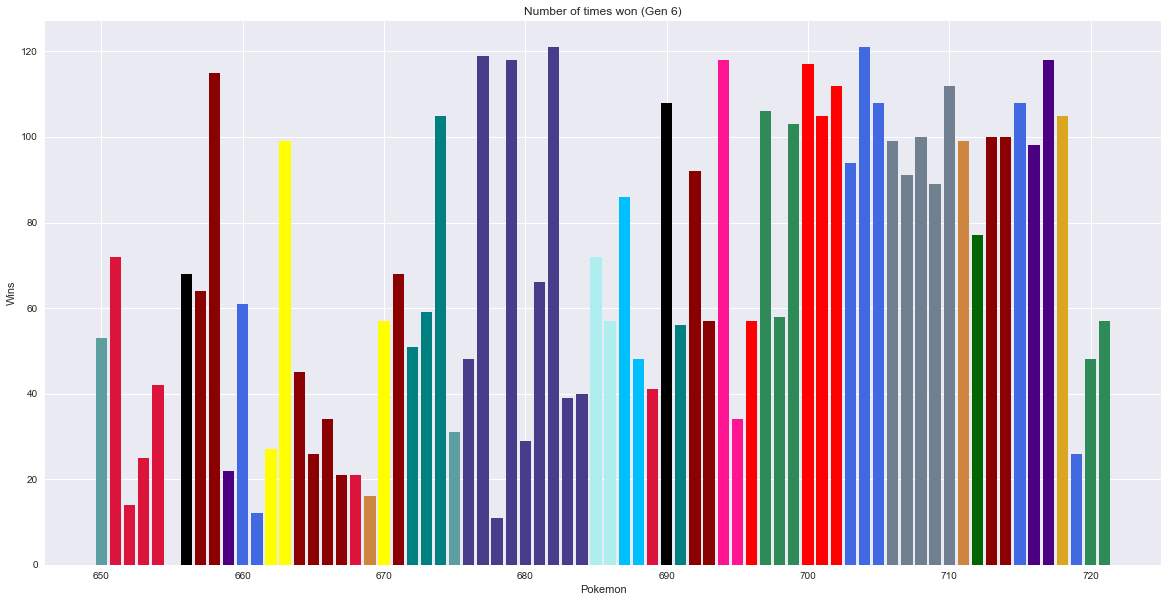

In [113]:
plt.figure(figsize=(20,10))
plt.title('Number of times won (Gen 6)')
plt.xlabel('Pokemon')
plt.ylabel('Wins')
plt.bar(hist_types(stats_n_df, data_df, 'Grass', 650, 721).index, hist_types(stats_n_df, data_df, 'Grass', 650, 721), color='seagreen')
plt.bar(hist_types(stats_n_df, data_df, 'Fire', 650, 721).index, hist_types(stats_n_df, data_df, 'Fire', 650, 721), color='Red')
plt.bar(hist_types(stats_n_df, data_df, 'Water', 650, 721).index, hist_types(stats_n_df, data_df, 'Water', 650, 721), color='royalblue')
plt.bar(hist_types(stats_n_df, data_df, 'Bug', 650, 721).index, hist_types(stats_n_df, data_df, 'Bug', 650, 721), color='darkgreen')
plt.bar(hist_types(stats_n_df, data_df, 'Normal', 650, 721).index, hist_types(stats_n_df, data_df, 'Normal', 650, 721), color='slategrey')
plt.bar(hist_types(stats_n_df, data_df, 'Poison', 650, 721).index, hist_types(stats_n_df, data_df, 'Poison', 650, 721), color='indigo')
plt.bar(hist_types(stats_n_df, data_df, 'Electric', 650, 721).index, hist_types(stats_n_df, data_df, 'Electric', 650, 721), color='yellow')
plt.bar(hist_types(stats_n_df, data_df, 'Ground', 650, 721).index, hist_types(stats_n_df, data_df, 'Ground', 650, 721), color='goldenrod')
plt.bar(hist_types(stats_n_df, data_df, 'Fairy', 650, 721).index, hist_types(stats_n_df, data_df, 'Fairy', 650, 721), color='crimson')
plt.bar(hist_types(stats_n_df, data_df, 'Fighting', 650, 721).index, hist_types(stats_n_df, data_df, 'Fighting', 650, 721), color='peru')
plt.bar(hist_types(stats_n_df, data_df, 'Psychic', 650, 721).index, hist_types(stats_n_df, data_df, 'Psychic', 650, 721), color='deeppink')
plt.bar(hist_types(stats_n_df, data_df, 'Rock', 650, 721).index, hist_types(stats_n_df, data_df, 'Rock', 650, 721), color='darkred')
plt.bar(hist_types(stats_n_df, data_df, 'Ghost', 650, 721).index, hist_types(stats_n_df, data_df, 'Ghost', 650, 721), color='darkslateblue')
plt.bar(hist_types(stats_n_df, data_df, 'Ice', 650, 721).index, hist_types(stats_n_df, data_df, 'Ice', 650, 721), color='paleturquoise')
plt.bar(hist_types(stats_n_df, data_df, 'Dragon', 650, 721).index, hist_types(stats_n_df, data_df, 'Dragon', 650, 721), color='teal')
plt.bar(hist_types(stats_n_df, data_df, 'Dark', 650, 721).index, hist_types(stats_n_df, data_df, 'Dark', 650, 721), color='black')
plt.bar(hist_types(stats_n_df, data_df, 'Steel', 650, 721).index, hist_types(stats_n_df, data_df, 'Steel', 650, 721), color='cadetblue')
plt.bar(hist_types(stats_n_df, data_df, 'Flying', 650, 721).index, hist_types(stats_n_df, data_df, 'Flying', 650, 721), color='deepskyblue')
plt.show()

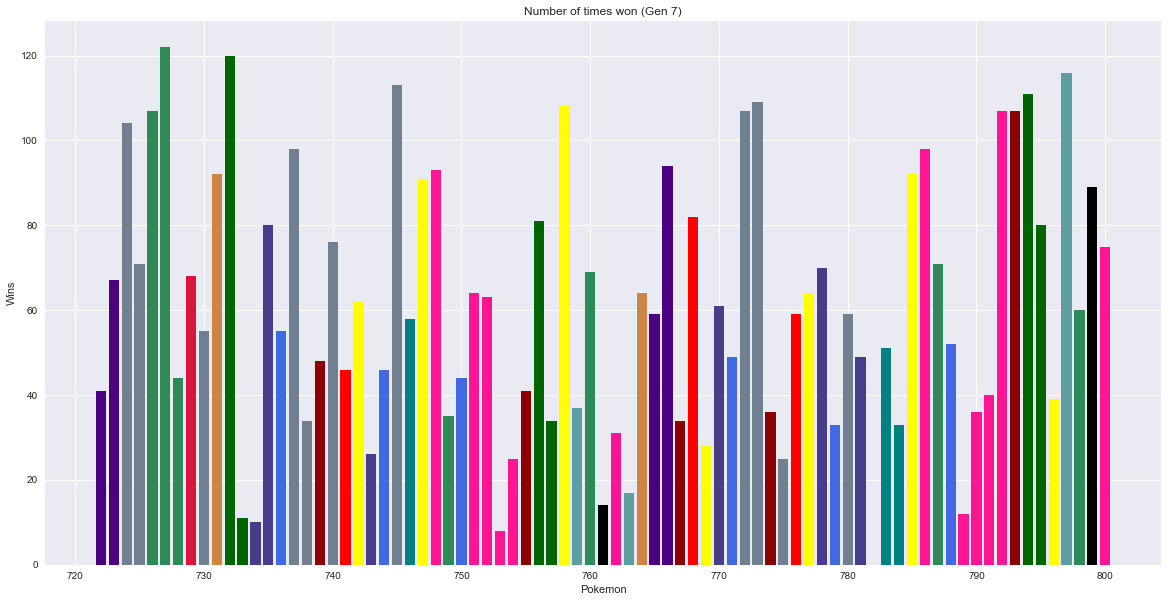

In [120]:
plt.figure(figsize=(20,10))
plt.title('Number of times won (Gen 7)')
plt.xlabel('Pokemon')
plt.ylabel('Wins')
plt.bar(hist_types(stats_n_df, data_df, 'Grass', 722, 890).index, hist_types(stats_n_df, data_df, 'Grass', 722, 890), color='seagreen')
plt.bar(hist_types(stats_n_df, data_df, 'Fire', 722, 890).index, hist_types(stats_n_df, data_df, 'Fire', 722, 890), color='Red')
plt.bar(hist_types(stats_n_df, data_df, 'Water', 722, 890).index, hist_types(stats_n_df, data_df, 'Water', 722, 890), color='royalblue')
plt.bar(hist_types(stats_n_df, data_df, 'Bug', 722, 890).index, hist_types(stats_n_df, data_df, 'Bug', 722, 890), color='darkgreen')
plt.bar(hist_types(stats_n_df, data_df, 'Normal', 722, 890).index, hist_types(stats_n_df, data_df, 'Normal', 722, 890), color='slategrey')
plt.bar(hist_types(stats_n_df, data_df, 'Poison', 722, 890).index, hist_types(stats_n_df, data_df, 'Poison', 722, 890), color='indigo')
plt.bar(hist_types(stats_n_df, data_df, 'Electric', 722, 890).index, hist_types(stats_n_df, data_df, 'Electric', 722, 890), color='yellow')
plt.bar(hist_types(stats_n_df, data_df, 'Ground', 722, 890).index, hist_types(stats_n_df, data_df, 'Ground', 722, 890), color='goldenrod')
plt.bar(hist_types(stats_n_df, data_df, 'Fairy', 722, 890).index, hist_types(stats_n_df, data_df, 'Fairy', 722, 890), color='crimson')
plt.bar(hist_types(stats_n_df, data_df, 'Fighting', 722, 890).index, hist_types(stats_n_df, data_df, 'Fighting', 722, 890), color='peru')
plt.bar(hist_types(stats_n_df, data_df, 'Psychic', 722, 890).index, hist_types(stats_n_df, data_df, 'Psychic', 722, 890), color='deeppink')
plt.bar(hist_types(stats_n_df, data_df, 'Rock', 722, 890).index, hist_types(stats_n_df, data_df, 'Rock', 722, 890), color='darkred')
plt.bar(hist_types(stats_n_df, data_df, 'Ghost', 722, 890).index, hist_types(stats_n_df, data_df, 'Ghost', 722, 890), color='darkslateblue')
plt.bar(hist_types(stats_n_df, data_df, 'Ice', 722, 890).index, hist_types(stats_n_df, data_df, 'Ice', 722, 890), color='paleturquoise')
plt.bar(hist_types(stats_n_df, data_df, 'Dragon', 722, 890).index, hist_types(stats_n_df, data_df, 'Dragon', 722, 890), color='teal')
plt.bar(hist_types(stats_n_df, data_df, 'Dark', 722, 890).index, hist_types(stats_n_df, data_df, 'Dark', 722, 890), color='black')
plt.bar(hist_types(stats_n_df, data_df, 'Steel', 722, 890).index, hist_types(stats_n_df, data_df, 'Steel', 722, 890), color='cadetblue')
plt.bar(hist_types(stats_n_df, data_df, 'Flying', 722, 890).index, hist_types(stats_n_df, data_df, 'Flying', 722, 890), color='deepskyblue')
plt.show()

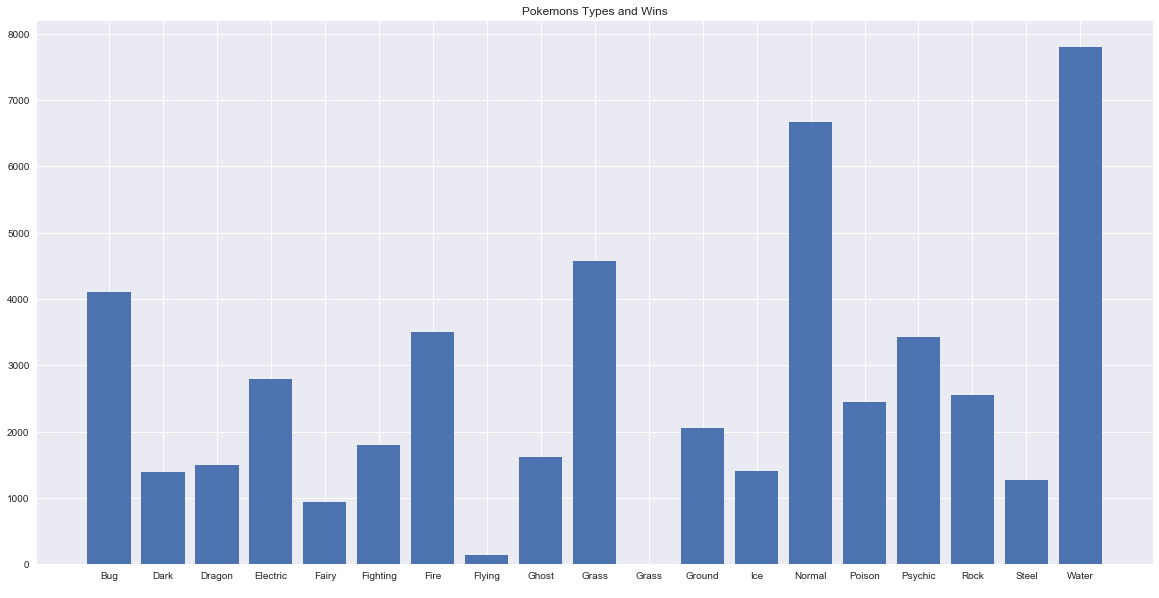

In [333]:
type_winner = pd.concat([stats_n_df, pd.DataFrame(data_df['Winner'].value_counts().tolist())], axis=1)
type_winner = type_winner.rename(columns = {0:'Wins'})  # Change the name of the new column
type_winner['Wins'] = type_winner['Wins'].fillna(0).astype(int)

plt.figure(figsize=(20,10))
plt.title('Pokemons Types and Wins')
plt.bar(pd.Series(list(range(type_winner.groupby(['Type1']).sum()['Wins'].shape[0]))), type_winner.groupby(['Type1']).sum()['Wins'])
plt.xticks(pd.Series(list(range(type_winner.groupby(['Type1']).sum()['Wins'].shape[0]))), type_winner.groupby(['Type1']).sum().index)
plt.show()

Let us look at the quantitative criteria. First we use the __winning percentage__ of each Pokemons. 

In [197]:
total_appear = data_df.groupby('First_pokemon').count().iloc[:,0].add(data_df.groupby('Second_pokemon').count().iloc[:,0])
wins = pd.DataFrame((data_df['Winner'].value_counts().sort_index()/(total_appear)).tolist())  # I need to reindex the series by convert to list then back to df
# wins.fillna(0, inplace=True)
# print(wins)
super_table = pd.concat([stats_n_df, wins], ignore_index=True, axis=1)
super_table.columns = ['Index', 'No', 'Name', 'Type1', 'Type2', 'HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed', 'Total', 'Average', 'Generation', 'Legendary', 'Percent']
super_table = super_table.drop(['Index'], axis=1)

In [205]:
super_table.head(20)

,No,Name,Type1,Type2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Generation,Legendary,Percent
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,318,53.00,1,0,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,405,67.50,1,0,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,525,87.50,1,0,0.674242
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,309,51.50,1,0,0.560000
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,405,67.50,1,0,0.491071
5,6,Charizard,Fire,Flying,78,84,78,109,85,100,534,89.00,1,0,0.542373
6,7,Squirtle,Water,NaN,44,48,65,50,64,43,314,52.33,1,0,0.864662
7,8,Wartortle,Water,NaN,59,63,80,65,80,58,405,67.50,1,0,0.856115
8,9,Blastoise,Water,NaN,79,83,100,85,105,78,530,88.33,1,0,0.844444
9,10,Caterpie,Bug,NaN,45,30,35,20,20,45,195,32.50,1,0,0.162393


Let us find out which Pokemons has the worst winning percentage. 

In [210]:
super_table.sort_values(by=['Percent'], ascending=True).head(10)

,No,Name,Type1,Type2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Generation,Legendary,Percent
280,281,Kirlia,Steel,NaN,38,35,35,65,55,50,278,46.33,3,0,0.021739
181,182,Bellossom,Steel,Ground,75,80,95,90,100,50,490,81.67,2,0,0.024590
624,625,Bisharp,Grass,Fighting,65,125,100,60,70,70,490,81.67,6,0,0.031008
227,228,Houndour,Grass,NaN,45,60,30,80,50,65,330,55.00,3,0,0.032520
563,564,Tirtouga,Grass,Steel,54,78,103,53,45,22,355,59.17,5,0,0.039062
180,181,Ampharos,Normal,NaN,90,75,85,115,90,55,510,85.00,2,0,0.043478
384,385,Jirachi,Rock,Steel,100,100,100,100,100,100,600,100.00,4,0,0.046154
201,202,Wobbuffet,Psychic,NaN,190,33,58,33,58,33,405,67.50,2,0,0.048000
282,283,Surskit,Fighting,Psychic,40,30,32,50,52,65,269,44.83,3,0,0.052632
737,738,Vikavolt,Normal,NaN,77,70,90,145,75,43,500,83.33,7,0,0.060150


Let us find out who are the winning Pokemons. 

In [201]:
super_table.sort_values(by=['Percent'], ascending=False).head(10)
# wins.sort_values().head(10).index.tolist()
# stats_df[stats_df['No'].isin(wins.sort_values(ascending=True).head(10).index.tolist())]

,No,Name,Type1,Type2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Generation,Legendary,Percent
147,148,Dragonair,Dragon,NaN,61,84,65,70,70,70,420,70.00,2,0,0.984496
500,501,Oshawott,Ground,Steel,55,55,45,63,45,45,308,51.33,5,0,0.974790
688,689,Barbaracle,Fairy,NaN,72,105,115,54,86,68,500,83.33,6,0,0.968000
18,19,Rattata,Normal,NaN,30,56,35,25,35,72,253,42.17,1,0,0.966387
146,147,Dratini,Dragon,NaN,41,64,45,50,50,50,300,50.00,2,1,0.964539
465,466,Electivire,Psychic,NaN,75,123,67,95,85,95,540,90.00,4,0,0.961240
711,712,Bergmite,Bug,Fairy,55,69,85,32,35,28,304,50.67,7,0,0.960630
701,702,Dedenne,Fire,Dark,67,58,57,81,67,101,431,71.83,7,0,0.959350
157,158,Totodile,Water,NaN,50,65,64,44,48,43,314,52.33,2,0,0.952000
339,340,Whiscash,Water,NaN,110,78,73,76,71,60,468,78.00,3,0,0.950000


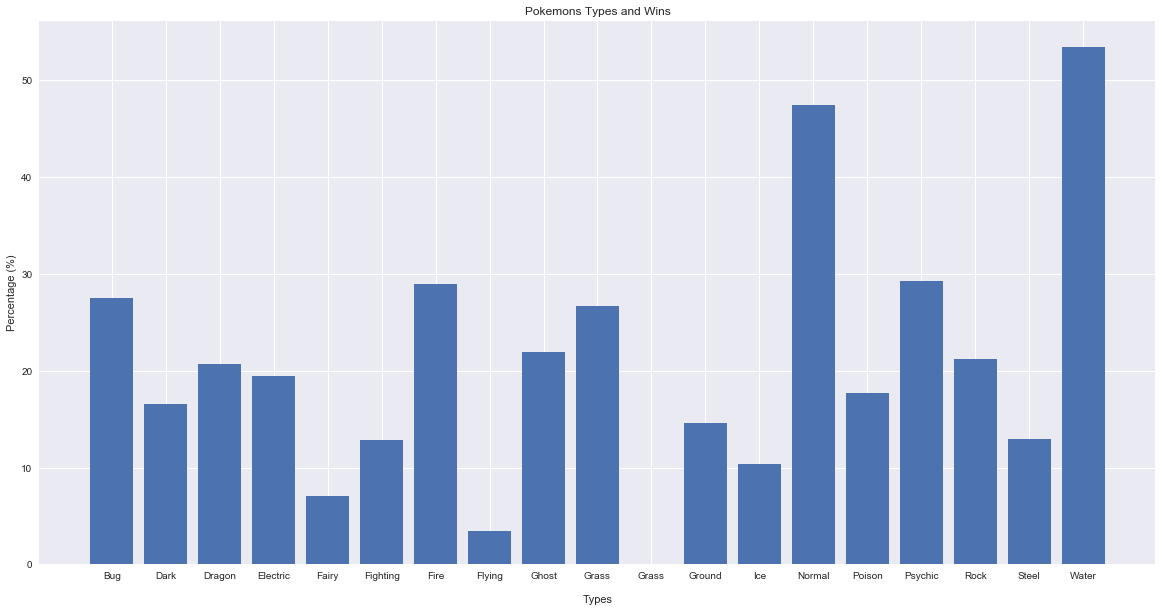

In [336]:
plt.figure(figsize=(20,10))
plt.title('Pokemons Types and Wins')
plt.ylabel('Percentage (%)')
plt.xlabel('Types')
plt.bar(pd.Series(list(range(super_table.groupby(['Type1']).sum()['Percent'].shape[0]))), super_table.groupby(['Type1']).sum()['Percent'])
plt.xticks(pd.Series(list(range(super_table.groupby(['Type1']).sum()['Percent'].shape[0]))), super_table.groupby(['Type1']).sum().index)
plt.show()

Let us look at a more numerical criteria. We could use proportion of wins, but we could also use odds to show how likely the pokemon will win overall. It is defined as 
$$ \text{odds} = \frac{W}{L}$$
We can say if the Pokemon has odds larger than 1, then it is a competitive species. 

In [215]:
odds = data_df['Winner'].value_counts()/(data_df['First_pokemon'].value_counts()+data_df['Second_pokemon'].value_counts()-data_df['Winner'].value_counts())

In [216]:
print('There are {} pokemons that are more likely to win.'.format(odds[odds >= 1].count()))
print('There are {} pokemons that are less likely to win.'.format(odds[odds < 1].count()))

There are 390 pokemons that are more likely to win.
There are 393 pokemons that are less likely to win.


Let's sort them and see which pokemon has the highest odds to win. 

In [218]:
# print(odds.sort_values(ascending=False).head(10))
odds.sort_values(ascending=False).head(10).index.tolist()
stats_df[stats_df['No'].isin(odds.sort_values(ascending=False).head(10).index.tolist())]

,No,Name,Type1,Type2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Generation,Legendary
26,20,Raticate,Normal,NaN,55,81,60,50,70,97,413,68.83,1,0
27,20,Raticate (Alolan Raticate),Dark,Normal,75,71,70,40,80,77,413,68.83,1,0
195,154,Meganium,Grass,NaN,80,82,100,83,100,80,525,87.50,2,0
196,155,Cyndaquil,Fire,NaN,39,52,43,60,50,65,309,51.50,2,0
206,165,Ledyba,Bug,Flying,40,20,30,40,80,55,265,44.17,2,0
412,350,Milotic,Steel,Psychic,95,60,79,100,125,81,540,90.00,3,0
559,477,Dusknoir,Fire,Fighting,45,100,135,65,135,45,525,87.50,5,0
602,513,Pansear,Bug,Grass,50,53,48,53,48,64,316,52.67,5,0
808,704,Goomy,Water,NaN,45,50,35,55,75,40,300,50.00,7,0
827,717,Yveltal,Dark,Flying,126,131,95,131,98,99,680,113.33,7,1


What about the lowest ones?

In [219]:
odds.sort_values(ascending=True).head(10).index.tolist()
stats_df[stats_df['No'].isin(odds.sort_values(ascending=True).head(10).index.tolist())]

,No,Name,Type1,Type2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Generation,Legendary
231,189,Jumpluff,Bug,Rock,75,55,70,55,95,110,460,76.67,2,0
232,190,Aipom,Bug,Fighting,55,70,55,40,55,85,360,60.00,2,0
253,210,Granbull,Normal,NaN,90,120,75,60,60,45,450,75.00,2,0
284,237,Hitmontop,Water,Ground,50,95,95,35,110,70,455,75.83,3,0
344,290,Nincada,Bug,NaN,31,45,90,30,30,40,266,44.33,3,0
346,292,Shedinja,Poison,NaN,1,90,45,30,30,40,236,39.33,3,0
470,395,Empoleon,Water,NaN,84,86,88,111,101,60,530,88.33,4,0
672,577,Solosis,Dragon,NaN,45,30,40,105,50,20,290,48.33,5,0
735,639,Terrakion,Rock,Fighting,91,129,90,72,90,108,580,96.67,6,1
870,753,Fomantis,Psychic,Steel,40,55,35,50,35,35,250,41.67,7,0


## Total and Odds

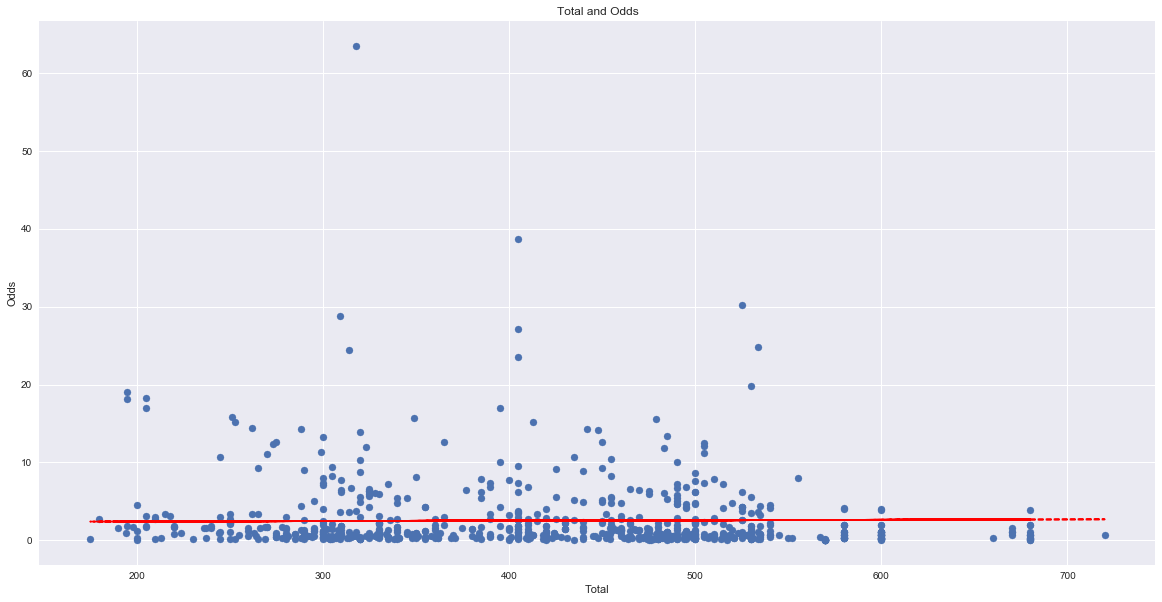

In [27]:
# print(odds.sort_values(ascending=False))
# print(stats_n_df.loc[stats_n_df.No.isin(odds.index), 'Total'].shape)
plt.figure(figsize=(20,10))
plt.title('Total and Odds')
plt.xlabel('Total')
plt.ylabel('Odds')
plt.scatter(stats_n_df.loc[stats_n_df.No.isin(odds.index), 'Total'], odds.sort_values(ascending=False))
z = np.polyfit(stats_n_df.loc[stats_n_df.No.isin(odds.index), 'Total'].fillna(0), odds.fillna(0), 1)
p = np.poly1d(z)
plt.plot(stats_n_df.loc[stats_n_df.No.isin(odds.index), 'Total'].fillna(0),p(stats_n_df.loc[stats_n_df.No.isin(odds.index), 'Total'].fillna(0)),"r--")
plt.show()

In [28]:
x = stats_n_df.loc[stats_n_df.No.isin(odds.index), 'Total'].fillna(0)
y = odds.fillna(0)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print('The relation between total values and odds: y = {:0.4f} + {:0.4f}x. \nR2 = {:0.4f}\tp-value = {:0.4f}'.format(intercept, slope, r_value, p_value))

The relation between total values and odds: y = 2.3032 + 0.0005x. 
R2 = 0.0126	p-value = 0.7248


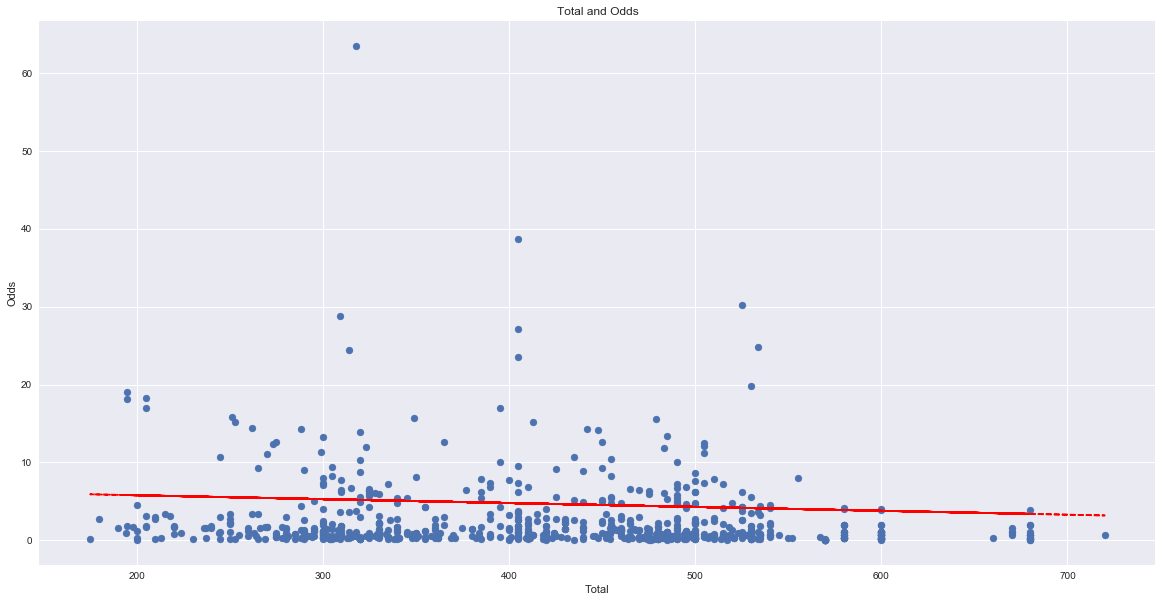

The relation between total values and odds: y = 6.7723 + -0.0050x. 
R2 = -0.0939	p-value = 0.0639


In [29]:
# print(odds[odds>=1].sort_values(ascending=False).shape)
# print(stats_n_df.loc[stats_n_df.No.isin(odds[odds>=1].index), 'Total'].shape)

plt.figure(figsize=(20,10))
plt.title('Total and Odds')
plt.xlabel('Total')
plt.ylabel('Odds')
x1 = stats_n_df.loc[stats_n_df.No.isin(odds[odds>=1].index), 'Total']
y1 = odds[odds>=1].sort_values(ascending=False)
plt.scatter(stats_n_df.loc[stats_n_df.No.isin(odds.index), 'Total'], odds.sort_values(ascending=False))
z = np.polyfit(x1, y1, 1)
p = np.poly1d(z)
plt.plot(x1,p(x1),"r--")
plt.show()

slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(x1, y1)
print('The relation between total values and odds: y = {:0.4f} + {:0.4f}x. \nR2 = {:0.4f}\tp-value = {:0.4f}'.format(intercept1, slope1, r_value1, p_value1))